##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Sketch2Paint with Gemini 2.0 Flash Image Generation

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Sketch2Paint.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>


This notebook is an implementation of converting hand-drawn sketches to creative paintings using Gemini Flash 2.0 Image Generation model.

<!-- Community Contributor Badge -->
<table>
  <tr>
    <!-- Author Avatar Cell -->
    <td bgcolor="#d7e6ff">
      <a href="https://github.com/NSTiwari" target="_blank" title="View Nitin Tiwari's profile on GitHub">
        <img src="https://github.com/NSTiwari.png?size=100"
             alt="NSTiwari's GitHub avatar"
             width="100"
             height="100">
      </a>
    </td>
    <!-- Text Content Cell -->
    <td bgcolor="#d7e6ff">
      <h2><font color='black'>This notebook was contributed by <a href="https://github.com/NSTiwari" target="_blank"><font color='#217bfe'><strong>Nitin Tiwari</strong></font></a>.</font></h2>
      <h5><font color='black'><a href="https://linkedin.com/in/tiwari-nitin"><font color="#078efb">LinkedIn</font></a> - See <a href="https://github.com/NSTiwari" target="_blank"><font color="#078efb"><strong>Nitin</strong></font></a> other notebooks <a href="https://github.com/search?q=repo%3Agoogle-gemini%2Fcookbook%20%22This%20notebook%20was%20contributed%20by%20Nitin%20Tiwari%22&type=code" target="_blank"><font color="#078efb">here</font></a>.</h5></font><br>
      <!-- Footer -->
      <font color='black'><small><em>Have a cool Gemini example? Feel free to <a href="https://github.com/google-gemini/cookbook/blob/main/CONTRIBUTING.md" target="_blank"><font color="#078efb">share it too</font></a>!</em></small></font>
    </td>
  </tr>
</table>

>**Note:** For the web application, refer to this [repository](https://github.com/NSTiwari/Sketch2Paint-Gemini).

## Before you begin

Before starting, ensure you have the following prerequisites in place:

* **Gemini API Access:** Make sure you have access to the Gemini API.

* **GCP Account:** You’ll need an active GCP account with a billing project set up and the Vertex AI API enabled. If you’re unsure how to get started, follow the instructions in this setup [guide](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).


Once you have these ready, you're good to go.

## Step 1: Install Gen AI SDK

In [1]:
%pip install -U -q google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.5/199.5 kB 4.9 MB/s eta 0:00:00


## Step 2: Import libraries

In [2]:
from IPython.display import HTML, display
import base64
from google.colab import output
from google import genai
from google.genai import types
from google.colab import userdata
from PIL import Image
from io import BytesIO
import base64

## Step 3: Configure Gemini API key

To run the following cell, your Gemini API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](../quickstarts/Authentication.ipynb) for an example.

In [18]:
# Comfigure Gemini API key.
GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')
client = genai.Client(api_key=GEMINI_API_KEY)

# Configure model.
MODEL_ID = "gemini-2.0-flash-exp-image-generation" # @param ["gemini-2.0-flash-exp-image-generation"] {"allow-input":true}

#### System Instructions

In [5]:
system_instructions = """
    You are an AI assistant specializing in transforming hand-drawn sketches into photorealistic paintings.
Your task is to take the user's uploaded sketch and a specified artistic style (e.g., oil painting, watercolor, crayon, pastel, charcoal, impressionist, digital painting) and generate a high-quality, photorealistic painting based on that sketch in the chosen style.
Interpret the sketch's content and composition, then render it with appropriate colors, textures, lighting, and details characteristic of the requested style.
"""

safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]

## Step 4: Draw a sketch on canvas
Now, it's time to get creative. Run the cell below to activate the interactive canvas. Use your mouse or stylus to draw the sketch you wish to convert into a painting.

*Tip: Clear, distinct lines often yield the best results for the AI transformation, but feel free to experiment.*

In [6]:
from IPython.display import HTML, display
import base64
from google.colab import output


CANVAS_WIDTH = 600
CANVAS_HEIGHT = 400
DEFAULT_COLOR = "#000000"
DEFAULT_LINE_WIDTH = 5
BACKGROUND_COLOR = "#FFFFFF"
COLAB_SAVE_FILENAME = "my_sketch.png"

# Python function to be called from JavaScript.
def save_sketch_to_colab(data_url, filename=COLAB_SAVE_FILENAME):
    """Decodes a base64 data URL and saves it to a file in Colab."""
    try:
        # data_url format: "data:image/png;base64,iVBORw0KGgo..."
        header, encoded = data_url.split(",", 1)
        image_data = base64.b64decode(encoded)

        with open(filename, "wb") as f:
            f.write(image_data)
        print(f"Sketch saved to Colab instance as: /content/{filename}")
        print("You can find it in the file browser on the left.")
    except Exception as e:
        print(f"Error saving sketch to Colab: {e}")

# Register the Python function so JavaScript can call it
output.register_callback('notebook.saveSketchToColab', save_sketch_to_colab)


html_code = f"""
<div style="display: flex; flex-direction: column; align-items: center; font-family: sans-serif;">
    <h2>Canvas Sketchpad</h2>
    <div style="margin-bottom: 10px;">
        <label for="colorPicker">Color:</label>
        <input type="color" id="colorPicker" value="{DEFAULT_COLOR}">

        <label for="lineWidth" style="margin-left: 15px;">Line Width:</label>
        <input type="range" id="lineWidth" min="1" max="50" value="{DEFAULT_LINE_WIDTH}">
        <span id="lineWidthValue">{DEFAULT_LINE_WIDTH}</span>px

        <button id="clearButton" style="margin-left: 15px;">Clear</button>
        <button id="eraserButton" style="margin-left: 5px;">Eraser</button>
        <button id="downloadButton" style="margin-left: 15px;">Download (Local)</button>
        <button id="saveToColabButton" style="margin-left: 5px;">Save to Colab Instance</button>
    </div>
    <canvas id="sketchCanvas" width="{CANVAS_WIDTH}" height="{CANVAS_HEIGHT}" style="border: 2px solid #000; background-color: {BACKGROUND_COLOR}; cursor: crosshair;"></canvas>
    <p style="font-size: 0.8em; color: #555;">Draw with your mouse on the canvas above.</p>
    <p id="statusMessage" style="font-size: 0.9em; color: green; margin-top: 5px;"></p>
</div>

<script>
    const canvas = document.getElementById('sketchCanvas');
    const ctx = canvas.getContext('2d');
    const colorPicker = document.getElementById('colorPicker');
    const lineWidthInput = document.getElementById('lineWidth');
    const lineWidthValue = document.getElementById('lineWidthValue');
    const clearButton = document.getElementById('clearButton');
    const eraserButton = document.getElementById('eraserButton');
    const downloadButton = document.getElementById('downloadButton');
    const saveToColabButton = document.getElementById('saveToColabButton');
    const statusMessage = document.getElementById('statusMessage');


    let isDrawing = false;
    let lastX = 0;
    let lastY = 0;
    let currentStrokeStyle = '{DEFAULT_COLOR}';

    ctx.strokeStyle = '{DEFAULT_COLOR}';
    ctx.lineWidth = {DEFAULT_LINE_WIDTH};
    ctx.lineJoin = 'round';
    ctx.lineCap = 'round';

    function getMousePos(canvasDom, event) {{
        const rect = canvasDom.getBoundingClientRect();
        return {{
            x: event.clientX - rect.left,
            y: event.clientY - rect.top
        }};
    }}

    function startDrawing(e) {{
        isDrawing = true;
        const mousePos = getMousePos(canvas, e);
        [lastX, lastY] = [mousePos.x, mousePos.y];
        if (e.touches) {{
             [lastX, lastY] = [e.touches[0].clientX - canvas.getBoundingClientRect().left, e.touches[0].clientY - canvas.getBoundingClientRect().top];
        }}
        ctx.beginPath();
        ctx.moveTo(lastX, lastY);
    }}

    function draw(e) {{
        if (!isDrawing) return;
        e.preventDefault();
        const mousePos = getMousePos(canvas, e);
        let currentX = mousePos.x;
        let currentY = mousePos.y;
        if (e.touches) {{
            currentX = e.touches[0].clientX - canvas.getBoundingClientRect().left;
            currentY = e.touches[0].clientY - canvas.getBoundingClientRect().top;
        }}
        ctx.lineTo(currentX, currentY);
        ctx.stroke();
        [lastX, lastY] = [currentX, currentY];
    }}

    function stopDrawing() {{
        if (isDrawing) {{
            ctx.closePath();
            isDrawing = false;
        }}
    }}

    canvas.addEventListener('mousedown', startDrawing);
    canvas.addEventListener('mousemove', draw);
    canvas.addEventListener('mouseup', stopDrawing);
    canvas.addEventListener('mouseout', stopDrawing);
    canvas.addEventListener('touchstart', (e) => {{ e.preventDefault(); startDrawing(e); }});
    canvas.addEventListener('touchmove', (e) => {{ e.preventDefault(); draw(e); }});
    canvas.addEventListener('touchend', stopDrawing);
    canvas.addEventListener('touchcancel', stopDrawing);

    colorPicker.addEventListener('input', (e) => {{
        ctx.strokeStyle = e.target.value;
        currentStrokeStyle = e.target.value;
    }});

    lineWidthInput.addEventListener('input', (e) => {{
        ctx.lineWidth = e.target.value;
        lineWidthValue.textContent = e.target.value;
    }});

    clearButton.addEventListener('click', () => {{
        ctx.clearRect(0, 0, canvas.width, canvas.height);
        statusMessage.textContent = '';
    }});

    eraserButton.addEventListener('click', () => {{
        if (ctx.strokeStyle !== '{BACKGROUND_COLOR}') {{
             currentStrokeStyle = ctx.strokeStyle;
        }}
        ctx.strokeStyle = '{BACKGROUND_COLOR}';
        colorPicker.value = '{BACKGROUND_COLOR}';
        statusMessage.textContent = '';
    }});

    downloadButton.addEventListener('click', () => {{
        statusMessage.textContent = '';
        const image = canvas.toDataURL('image/png').replace('image/png', 'image/octet-stream');
        const link = document.createElement('a');
        link.download = 'my-sketch.png';
        link.href = image;
        link.click();
    }});

    saveToColabButton.addEventListener('click', async () => {{
        statusMessage.textContent = 'Saving to Colab...';
        const dataURL = canvas.toDataURL('image/png');
        try {{
            // Call the Python function registered with 'notebook.saveSketchToColab'
            // The result of the Python print will appear in the cell output, not here directly.
            await google.colab.kernel.invokeFunction(
                'notebook.saveSketchToColab', // Registered callback name
                [dataURL, '{COLAB_SAVE_FILENAME}'], // Arguments for the Python function
                {{}} // kwargs
            );
            statusMessage.textContent = 'Save command sent. Check Colab output below.';
        }} catch (e) {{
            console.error("Error invoking Colab save function:", e);
            statusMessage.textContent = 'Error saving to Colab. See console.';
        }}
    }});

    colorPicker.addEventListener('change', (e) => {{
        if (ctx.strokeStyle === '{BACKGROUND_COLOR}' && e.target.value !== '{BACKGROUND_COLOR}') {{
            ctx.strokeStyle = e.target.value;
            currentStrokeStyle = e.target.value;
        }}
    }});

</script>
"""

display(HTML(html_code))

Sketch saved to Colab instance as: /content/my_sketch.png
You can find it in the file browser on the left.
Sketch saved to Colab instance as: /content/my_sketch.png
You can find it in the file browser on the left.


## Step 5: Generate your painting with Gemini 2.0 Flash Image Generation

Pass the input sketch image and the artistic style as part of the prompt to Gemini 2.0 Flash Image Generation model.

>**Note:** To achieve the best possible painting from your sketch, aim to include ample detail. Using distinct colors for different elements or features in your sketch can provide clearer guidance to the model.

In [25]:
input_image = 'my_sketch.png' # @param {type : 'string'}

style = "Digital Art" # @param ["Oil Painting","Water Color","Acrylic","Abstract Art","Digital Art"] {"allow-input":true}

prompt = f"Convert this input sketch into a beautiful, detailed painting in {style} style. The painting should be photorealistic and richly textured, capturing the essence of the chosen medium."

img = Image.open(input_image)

# Run model.
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[prompt, img],
    config=types.GenerateContentConfig(
        temperature=0.5,
        safety_settings=safety_settings,
        response_modalities=['TEXT', 'IMAGE']
    )
)

for part in response.candidates[0].content.parts:
  if part.text is not None:
    print(part.text)
  elif part.inline_data is not None:
    image = Image.open(BytesIO(part.inline_data.data))
    image.save('gemini-painting.png')
    image.show()

I will transform the sketch into a detailed digital painting. The scene will depict a tropical beach at sunset. A leaning palm tree with textured bark and vibrant green fronds will be on a sandy shore with visible grains. The ocean will be a mix of turquoise and deeper blues, reflecting the warm light of the setting sun, which will be a bright yellow with orange rays. A red sailboat with visible texture on its sail will be sailing on the water. The sky will transition from a dark night sky to lighter hues near the horizon, with a few fluffy white clouds and some darker, rain-like clouds rendered with depth and volume. The overall style will be photorealistic with rich textures to emulate a traditional painting.



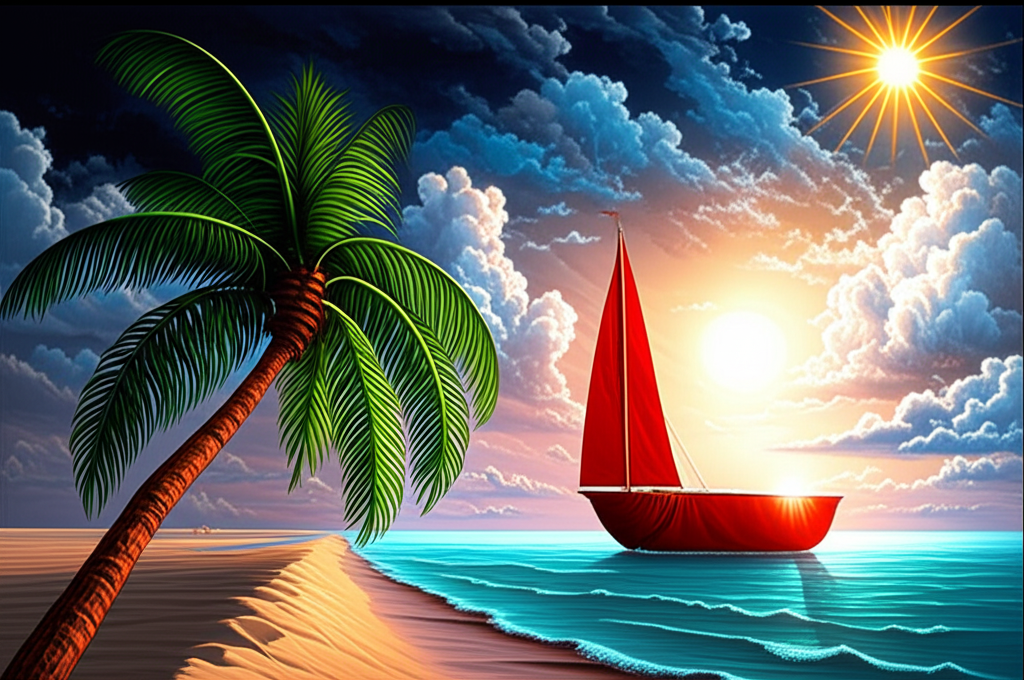

In [26]:
output_image = Image.open('gemini-painting.png')
display(output_image)

Congratulations on successfully completing this tutorial and creating beautiful paintings from your sketches using Gemini 2.0's native image generation capabilities.